# SNR

In [1]:
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

import sys
import os

# this is the path if you are running things from crispy/doc/source/notebooks/
folder = '../../../../crispy'

# add folder in your path to make crispy knows what's going on
if folder not in sys.path: sys.path.append(folder)

# this loads your parameter file; make sure your IFS parameters make sense
from crispy.params import Params
folder = '../../../crispy'

# initializes your parameters
par = Params(folder)

# initializes the logger; this helps to make sure things stay compatible across versions of Python
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

# just as a test, let's see what IFS you've got
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [6]:
%pylab inline --no-import-all
from crispy.tools.image import Image
# test = Image('/Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/offaxis_star_red_optext.fits')
from crispy.params import Params
from crispy.tools.inputScene import adjust_krist_header
from crispy.IFS import polychromeIFS

par = Params('../../../crispy')
offaxis = Image('/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits')
adjust_krist_header(offaxis,lamc=660.)
fileshape = offaxis.data.shape
par.saveRotatedInput = True
lamlist = 660.*np.linspace(1.-par.BW/2.,1.+par.BW/2.,fileshape[0])
detector = polychromeIFS(par,lamlist,offaxis,QE=False)

Populating the interactive namespace from numpy and matplotlib
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Writing data to ../../../crispy/SimResults/imagePlaneRot.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 29 seconds total


crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/imagePlaneRot.fits


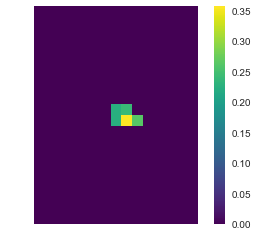

1.3131929338
0.597514053829
0.791325493521
[ 0.22502421  0.35702303  0.26380521  0.22576605  0.24157444]


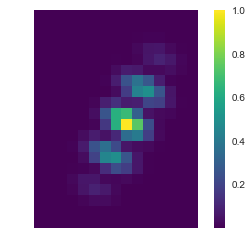

14.0502
2.31471
0.107556195176


In [14]:
test = Image(par.exportDir+'/imagePlaneRot.fits')
from crispy.tools.postprocessing import mf
from crispy.tools.imgtools import bowtie
ydim,xdim = test.data[0].shape
lamc=660
IWA=2.5
OWA=9
mask,scratch = bowtie(test.data[0],ydim//2-1,xdim//2,openingAngle=65,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    

matched_filter = mf(test,mask,0.5)
fig = matched_filter[10,20:40,40:55]
plt.imshow(fig,cmap='viridis')
plt.axis('off')
plt.colorbar()
plt.show()
print np.nansum(fig)
print np.sqrt(np.nansum(fig**2))
print (np.nansum(fig**3)/(np.nansum(fig**2))**2)
print fig[np.nonzero(fig)]

fig = test.data[10,20:40,40:55]
fig/=np.amax(fig)
fig[fig<0.0] = 0.0
plt.imshow(fig,cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.show()

print np.nansum(fig)
print np.sqrt(np.nansum(fig**2))
print (np.nansum(fig**3)/(np.nansum(fig**2))**2)
#print fig[np.nonzero(fig)]

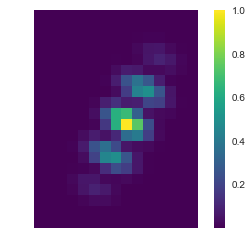

1.0000000596
0.455008612028
1.03916300061
[ 0.17135653  0.27187404  0.20088841  0.17192148  0.1839596 ]
0.264662764966
[ 0.04535169  0.07195493  0.05316768  0.04550121  0.04868726]


In [16]:
def mf2(cube,mask,threshold):
    '''
    Matched filter function
    
    Parameters
    ----------
    cube: 3D ndarray
        An IFS cube representing the offaxis PSF, from which to compute the matched filter
    mask: 2D ndarray
        This is typically the coronagraphic mask
    threshold: float
        Fraction of max below which we crop the normalized PSF
    
    Returns
    -------
    matched_filter: 3D ndarray
        Matched filter with the same dimensions as input cube
    
    '''
    matched_filter = np.zeros(cube.data.shape)
    
    for slicenum in range(cube.data.shape[0]):
        cube_norm = cube.data[slicenum]/np.nansum(cube.data[slicenum])
        msk = mask*(cube_norm>np.nanmax(cube_norm)*threshold)
        
        # zero out all pixels outside of the thresholded area
        cube_norm[~msk]=0.0
        
        # normalize
        cube_norm /= np.nansum(cube_norm)
        
        # this is now the final matched filter coefficients
        matched_filter[slicenum,:,:] = cube_norm#/np.nansum(cube_norm**2)
    return matched_filter

matched_filter2 = mf2(test,mask,0.0)
matched_filter3 = mf2(test,mask,0.5)
fig2 = matched_filter2[10,20:40,40:55]
fig3 = matched_filter3[10,20:40,40:55]
plt.imshow(fig,cmap='viridis')
plt.axis('off')
plt.colorbar()
plt.show()
print np.nansum(fig3)
print np.sqrt(np.nansum(fig3**2))
print (np.nansum(fig3**3)/(np.nansum(fig3**2))**2)
print fig3[np.nonzero(fig3)]
print np.sum(fig2[fig2/np.amax(fig2)>0.5])
print fig2[fig2/np.amax(fig2)>0.5]